## **Library**

In [26]:
import os
import re
import glob
import tqdm
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import soundfile as sf
from pathlib import Path
from collections import Counter
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras import Sequential, layers, models, optimizers, callbacks, mixed_precision

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [8]:
# check gpu availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## **Data**

In [9]:
audio_folder = r"C:\Users\Salim\Kuliah\Semester 5\Jaringan Syaraf Tiruan\Project\Project-JST\Data\IndoWaveSentiment"

actor_dirs = [f'Actor_{str(i).zfill(2)}' for i in range(1, 11)]
wav_files = []
for actor in actor_dirs:
    actor_path = os.path.join(audio_folder, actor, '*.wav')
    wav_files.extend(glob.glob(actor_path))
print(f"Total WAV files found: {len(wav_files)}")

# load all audio files and print their durations
for file in wav_files[:5]:  # just load first 5 files for demonstration
    audio, sr = librosa.load(file, sr=None)
    duration = len(audio) / sr
    print(f"File: {os.path.basename(file)}, Duration: {duration:.2f} seconds, Sample Rate: {sr} Hz")

# Print statistics about all durations
print("\nLoading all audio files to analyze durations...")
all_durations = []
for file in wav_files:
    audio, sr = librosa.load(file, sr=None)
    duration = len(audio) / sr
    all_durations.append(duration)

print(f"\nDuration Statistics:")
print(f"Total files: {len(all_durations)}")
print(f"Min duration: {min(all_durations):.2f} seconds")
print(f"Max duration: {max(all_durations):.2f} seconds")
print(f"Mean duration: {np.mean(all_durations):.2f} seconds")
print(f"Median duration: {np.median(all_durations):.2f} seconds")

Total WAV files found: 300


c:\Users\loq\anaconda3\envs\tf-audio-gpu\lib\site-packages\librosa\core\intervals.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


File: 01-01-01-01.wav, Duration: 3.00 seconds, Sample Rate: 44100 Hz
File: 01-01-01-02.wav, Duration: 3.00 seconds, Sample Rate: 44100 Hz
File: 01-01-01-03.wav, Duration: 3.00 seconds, Sample Rate: 44100 Hz
File: 01-01-02-01.wav, Duration: 3.00 seconds, Sample Rate: 44100 Hz
File: 01-01-02-02.wav, Duration: 3.00 seconds, Sample Rate: 44100 Hz

Loading all audio files to analyze durations...

Duration Statistics:
Total files: 300
Min duration: 3.00 seconds
Max duration: 3.80 seconds
Mean duration: 3.10 seconds
Median duration: 3.00 seconds


In [10]:
# Parameters
SR = 22050               # sampling rate
DURATION = 4.0           # target duration (seconds) -> semua file akan dipotong / dipadatkan
N_MELS = 128             # mel bins (freq)
N_FFT = 2048
HOP_LENGTH = 512
EPS = 1e-6
BATCH_SIZE = 32
RANDOM_STATE = 42

# helper: load, pad/trim, compute log-mel spectrogram, normalize per-sample
def file_to_log_mel(path, sr=SR, duration=DURATION, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
    y, _sr = librosa.load(path, sr=sr, mono=True)
    target_len = int(sr * duration)
    if len(y) < target_len:
        y = librosa.util.fix_length(y, size=target_len)   # pad with zeros
    else:
        y = y[:target_len]                                 # trim if longer
    # mel spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=2.0)
    log_mel = librosa.power_to_db(mel, ref=np.max)
    # normalize (mean-std) per sample
    log_mel = (log_mel - np.mean(log_mel)) / (np.std(log_mel) + EPS)
    return log_mel.astype(np.float32)   # shape: (n_mels, t_frames)

## **Augmentation**

In [11]:
# main path
project_root = Path(r"C:\Users\Salim\Kuliah\Semester 5\Jaringan Syaraf Tiruan\Project\Project-JST")
base_dir = str(project_root / "Data" / "IndoWaveSentiment")
output_base = str(project_root / "Data" / "IndoWaveSentiment_Augmented")

# create folder if not exists
os.makedirs(output_base, exist_ok=True)

# Define augmentation pipeline
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_shift=-0.5, max_shift=0.5, p=0.5)
])

for actor_folder in os.listdir(base_dir):
    actor_path = os.path.join(base_dir, actor_folder)
    if not os.path.isdir(actor_path):
        continue

    output_actor_path = os.path.join(output_base, actor_folder)
    os.makedirs(output_actor_path, exist_ok=True)

    for file_name in os.listdir(actor_path):
        if file_name.endswith(".wav"):
            file_path = os.path.join(actor_path, file_name)
            samples, sr = sf.read(file_path)

            if samples.dtype != np.float32:
                samples = samples.astype(np.float32)

            # augment
            augmented = augment(samples=samples, sample_rate=sr)

            aug_name = file_name.replace(".wav", "_aug.wav")
            output_path = os.path.join(output_actor_path, aug_name)
            sf.write(output_path, augmented, sr)

In [19]:
# label dictionary
label_map = {
    '01': 'neutral',
    '02': 'happy',
    '03': 'surprise',
    '04': 'disgust',
    '05': 'disappointed'
}

# Update wav_files to include both original and augmented files
wav_files_original = []
for actor in actor_dirs:
    actor_path = os.path.join(audio_folder, actor, '*.wav')
    wav_files_original.extend(glob.glob(actor_path))

wav_files_augmented = []
for actor in actor_dirs:
    actor_path = os.path.join(output_base, actor, '*_aug.wav')
    wav_files_augmented.extend(glob.glob(actor_path))

wav_files = wav_files_original + wav_files_augmented
print(f"Total original files: {len(wav_files_original)}")
print(f"Total augmented files: {len(wav_files_augmented)}")
print(f"Total WAV files: {len(wav_files)}")

def label_from_filename(filename):
    """
    Extract emotion code from filename robustly.
    Finds the first 2-digit token in the name that matches label_map keys.
    """
    fname = os.path.basename(filename)
    for code in re.findall(r'\d{2}', fname):
        if code in label_map:
            return label_map[code]
    return 'unknown'

labels = [label_from_filename(f) for f in wav_files]
print(labels[:10])

Total original files: 300
Total augmented files: 300
Total WAV files: 600
['neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral']


In [20]:
X_list = []
y_list = []
X_files = []
skipped = []

for fp in wav_files:
    lbl = label_from_filename(fp)
    if lbl == 'unknown':
        skipped.append(fp)
        continue
    try:
        spec = file_to_log_mel(fp)        # (n_mels, t_frames)
        X_list.append(spec)
        y_list.append(lbl)
        X_files.append(fp)
    except Exception as e:
        skipped.append(fp)
        print("Skipped", fp, ":", e)

if len(X_list) == 0:
    raise RuntimeError("No valid spectrograms. Check filenames and label_map.")

# Stack and add channel dim for Conv2D
X = np.stack(X_list, axis=0).astype(np.float32)   # (N, n_mels, t_frames)
X = np.expand_dims(X, -1)                         # (N, n_mels, t_frames, 1)
y = np.array(y_list)

print("Built dataset:", X.shape, "labels:", Counter(y))
if skipped:
    print("Skipped files:", len(skipped), "examples:", skipped[:5])

# Encode labels -> expect 5 classes
le = LabelEncoder()
y_enc = le.fit_transform(y)
print("Classes found:", le.classes_, "count:", len(le.classes_))
if len(le.classes_) != 5:
    print("Warning: expected 5 emotion classes. Verify label_map and filenames.")

# group-aware split
def group_key(path):
    # Group original and augmented versions together
    fname = os.path.basename(path)
    stem = fname.replace('_aug', '').replace('.wav', '')
    return stem

groups = np.array([group_key(fp) for fp in X_files])

gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=RANDOM_STATE)
train_idx, temp_idx = next(gss.split(X, y_enc, groups))

X_train, y_train = X[train_idx], y_enc[train_idx]
X_temp, y_temp = X[temp_idx], y_enc[temp_idx]
groups_temp = groups[temp_idx]

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=RANDOM_STATE)
val_idx, test_idx = next(gss2.split(X_temp, y_temp, groups_temp))

X_val, y_val = X_temp[val_idx], y_temp[val_idx]
X_test, y_test = X_temp[test_idx], y_temp[test_idx]

print("Splits:", X_train.shape, X_val.shape, X_test.shape)

# Recompute class weights on y_train
from sklearn.utils.class_weight import compute_class_weight
class_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)))
print("Class weights:", class_weights)

# Recreate tf.data datasets
def make_ds(Xa, ya, batch=BATCH_SIZE, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((Xa, ya))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(ya), 2048), seed=RANDOM_STATE)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(X_train, y_train, batch=BATCH_SIZE, shuffle=True)
val_ds = make_ds(X_val, y_val, batch=BATCH_SIZE, shuffle=False)
test_ds = make_ds(X_test, y_test, batch=BATCH_SIZE, shuffle=False)

Built dataset: (600, 128, 173, 1) labels: Counter({'neutral': 120, 'happy': 120, 'surprise': 120, 'disgust': 120, 'disappointed': 120})
Classes found: ['disappointed' 'disgust' 'happy' 'neutral' 'surprise'] count: 5
Splits: (480, 128, 173, 1) (60, 128, 173, 1) (60, 128, 173, 1)
Class weights: {0: 0.96, 1: 1.0434782608695652, 2: 1.0, 3: 0.9795918367346939, 4: 1.0212765957446808}


## **Feature Extraction**

In [14]:
# VGGish-inspired feature extractor
def build_vggish_feature_extractor(input_shape):
    """
    VGGish-inspired CNN for audio feature extraction.
    Original VGGish uses 64x96 mel spectrograms, but we adapt to our input shape.
    """
    model = Sequential([
        layers.Input(shape=input_shape),
        
        # Block 1
        layers.Conv2D(64, (3,3), padding='same', activation='relu', name='conv1'),
        layers.MaxPool2D((2,2), strides=(2,2), name='pool1'),
        
        # Block 2
        layers.Conv2D(128, (3,3), padding='same', activation='relu', name='conv2'),
        layers.MaxPool2D((2,2), strides=(2,2), name='pool2'),
        
        # Block 3
        layers.Conv2D(256, (3,3), padding='same', activation='relu', name='conv3_1'),
        layers.Conv2D(256, (3,3), padding='same', activation='relu', name='conv3_2'),
        layers.MaxPool2D((2,2), strides=(2,2), name='pool3'),
        
        # Block 4
        layers.Conv2D(512, (3,3), padding='same', activation='relu', name='conv4_1'),
        layers.Conv2D(512, (3,3), padding='same', activation='relu', name='conv4_2'),
        layers.MaxPool2D((2,2), strides=(2,2), name='pool4'),
        
        # Flatten and FC layers for embedding
        layers.Flatten(),
        layers.Dense(4096, activation='relu', name='fc1'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu', name='fc2'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu', name='vggish_embedding'),  # VGGish embedding layer
    ], name='VGGish_Feature_Extractor')
    
    return model

# Extract VGGish features for all splits
print("Building VGGish feature extractor...")
vggish_extractor = build_vggish_feature_extractor(input_shape=X_train.shape[1:])
vggish_extractor.summary()

print("\nExtracting VGGish features...")
X_train_vggish = vggish_extractor.predict(X_train, batch_size=BATCH_SIZE, verbose=1)
X_val_vggish = vggish_extractor.predict(X_val, batch_size=BATCH_SIZE, verbose=1)
X_test_vggish = vggish_extractor.predict(X_test, batch_size=BATCH_SIZE, verbose=1)

print(f"\nVGGish features shape:")
print(f"Train: {X_train_vggish.shape}")
print(f"Val: {X_val_vggish.shape}")
print(f"Test: {X_test_vggish.shape}")

# Save extracted features (optional)
save_features = True
if save_features:
    features_dir = project_root / "Data" / "vggish_features"
    os.makedirs(features_dir, exist_ok=True)
    
    np.save(str(features_dir / "X_train_vggish.npy"), X_train_vggish)
    np.save(str(features_dir / "X_val_vggish.npy"), X_val_vggish)
    np.save(str(features_dir / "X_test_vggish.npy"), X_test_vggish)
    np.save(str(features_dir / "y_train.npy"), y_train)
    np.save(str(features_dir / "y_val.npy"), y_val)
    np.save(str(features_dir / "y_test.npy"), y_test)
    
    print(f"\nFeatures saved to {features_dir}")

Building VGGish feature extractor...
Model: "VGGish_Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 128, 173, 64)      640       
                                                                 
 pool1 (MaxPooling2D)        (None, 64, 86, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 64, 86, 128)       73856     
                                                                 
 pool2 (MaxPooling2D)        (None, 32, 43, 128)       0         
                                                                 
 conv3_1 (Conv2D)            (None, 32, 43, 256)       295168    
                                                                 
 conv3_2 (Conv2D)            (None, 32, 43, 256)       590080    
                                                                 
 pool

## **Modelling**

In [21]:
try:
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled.")
except Exception as e:
    print("Mixed precision not enabled:", e)

Mixed precision enabled.


In [22]:
input_shape = X_train.shape[1:]   # (n_mels, t_frames, 1)
num_classes = len(np.unique(y_train))
print("Input shape:", input_shape, "Num classes:", num_classes)

mel_down = input_shape[0] // 4    # two 2x2 pools on frequency
feat_per_step = mel_down * 64     # 64 filters after second Conv2D

model = Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),

    # (mel/4, time/4, 64) -> (time/4, feat_per_step)
    layers.Permute((2,1,3)),
    layers.Reshape((-1, int(feat_per_step))),

    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])
model.summary()

model.compile(
    optimizer=optimizers.Adam(3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

ckpt_path = "cnn_bilstm_best.h5"
cbs = [
    callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1),
    callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
]

Input shape: (128, 173, 1) Num classes: 5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 173, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 128, 173, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 86, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 86, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 86, 64)       256       
 hNormalization)                                                 
              

In [23]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=cbs
)

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 1.6128 - accuracy: 0.2313
Epoch 1: val_loss improved from inf to 1.60046, saving model to cnn_bilstm_best.h5
15/15 [==============================] - 19s 340ms/step - loss: 1.6128 - accuracy: 0.2313 - val_loss: 1.6005 - val_accuracy: 0.3500 - lr: 3.0000e-04
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 1.5411 - accuracy: 0.2979
Epoch 2: val_loss improved from 1.60046 to 1.56751, saving model to cnn_bilstm_best.h5
15/15 [==============================] - 2s 99ms/step - loss: 1.5411 - accuracy: 0.2979 - val_loss: 1.5675 - val_accuracy: 0.4333 - lr: 3.0000e-04
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 1.4575 - accuracy: 0.3729
Epoch 3: val_loss improved from 1.56751 to 1.55736, saving model to cnn_bilstm_best.h5
15/15 [==============================] - 1s 91ms/step - loss: 1.4575 - accuracy: 0.3729 - val_loss: 1.5574 - val_accuracy: 0.4167 - lr: 3.0000e-04
Epoch 4/100
15/

In [24]:
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

2/2 [==============================] - 3s 30ms/step


## **Evaluation**

Test Accuracy: 0.8333
Test Precision: 0.8441
Test Recall: 0.8333
Test F1-Score: 0.8302
Classification report:
              precision    recall  f1-score   support

disappointed       0.71      0.50      0.59        10
     disgust       0.64      0.90      0.75        10
       happy       0.92      1.00      0.96        12
     neutral       1.00      0.83      0.91        12
    surprise       0.88      0.88      0.88        16

    accuracy                           0.83        60
   macro avg       0.83      0.82      0.82        60
weighted avg       0.84      0.83      0.83        60



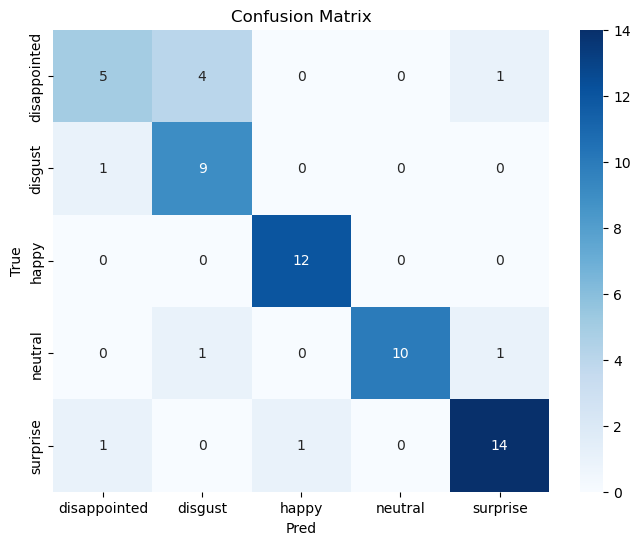

In [27]:
accuracy_score_val = accuracy_score(y_test, y_pred)
precision_score_val = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall_score_val = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1_score_val = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Test Accuracy: {accuracy_score_val:.4f}")
print(f"Test Precision: {precision_score_val:.4f}")
print(f"Test Recall: {recall_score_val:.4f}")
print(f"Test F1-Score: {f1_score_val:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.ylabel('True'); plt.xlabel('Pred')
plt.title('Confusion Matrix')
plt.show()